In [1]:
import torch
from torch import nn
import torch.nn.functional as F

from braindecode.datasets.sleep_physionet import SleepPhysionet
from braindecode.datautil.preprocess import MNEPreproc, NumpyPreproc, preprocess
from braindecode.datautil.windowers import create_windows_from_events
from braindecode.datautil.preprocess import zscore
from braindecode.util import set_random_seeds
from braindecode.datasets.base import BaseConcatDataset
from braindecode import EEGClassifier, EEGRegressor
from braindecode.models import SleepStagerChambon2018

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import bisect
import numpy as np

import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.base import TransformerMixin

from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import EpochScoring, ProgressBar
from skorch.helper import predefined_split
from skorch.utils import to_numpy

In [2]:
info = pd.read_excel('SC-subjects.xls')
info.head()

,subject,night,age,sex (F=1),LightsOff
0,0,1,33,1,00:38:00
1,0,2,33,1,21:57:00
2,1,1,33,1,22:44:00
3,1,2,33,1,22:15:00
4,2,1,26,1,22:50:00


In [3]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [4]:
sleep_cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', ['r', 'g', 'b', 'pink', 'orange'], len(['r', 'g', 'b', 'pink', 'orange']))

# Dataset Creation

In [5]:
bug_subjects = [36, 39, 48, 52, 65, 68, 69, 73, 75, 78, 79]
subject_ids = [id for id in range(83) if id not in bug_subjects]

dataset = SleepPhysionet(
    subject_ids=subject_ids, recording_ids=[0,1], crop_wake_mins=30)

Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4421E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4431E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4441E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_data/physionet-sleep-data/SC4451F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/285EDDF95EDDC02C/Users/Public/Documents/mne_d

In [6]:
high_cut_hz = 30

preprocessors = [
    # convert from volt to microvolt, directly modifying the numpy array
    NumpyPreproc(fn=lambda x: x * 1e6),
    # bandpass filter
    MNEPreproc(fn='filter', l_freq=None, h_freq=high_cut_hz),
]

# Transform the data
preprocess(dataset, preprocessors)

Reading 0 ... 2508000  =      0.000 ... 25080.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 2856000  =      0.000 ... 28560.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 2823000  =      0.000 

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 5661000  =      0.000 ... 56610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 4440000  =      0.000 ... 44400.000 secs...
Filtering raw data in


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3258000  =      0.000 ... 32580.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 5148000  =      0.000 ... 51480.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low

---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3081000  =      0.000 ... 30810.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 6627000  =      0.000 ... 66270.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz



In [7]:
mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

reverse_mapping = {v: k[-1] for k,v in mapping.items()}

window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq

windows_dataset = create_windows_from_events(
    dataset, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples, preload=True, mapping=mapping)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
837 matching events found
No baseline correction applied
0 projection items activated
Loading data for 837 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1088 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1088 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1021 matching events found
No baseli

0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1098 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1098 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
903 matching events found
No baseline correction applied
0 projection items activated
Loading data for 903 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1650 matching events found
No baseline correction

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
982 matching events found
No baseline correction applied
0 projection items activated
Loading data for 982 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1185 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1185 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1100 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1100 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations

0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1683 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1683 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1325 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1325 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1241 matching events found
No baseline correction applied
0 proj

In [8]:
preprocess(windows_dataset, [MNEPreproc(fn=zscore)])

In [9]:
windows_dataset.datasets[0].windows.get_data().shape

(837, 2, 3000)

In [10]:
class TimeContrastiveDataset(BaseConcatDataset):
    """
    ----------
    list_of_ds: list
        list of BaseDataset, BaseConcatDataset or WindowsDataset
    """
    def __init__(self, list_of_ds, delta_index_positive=10, delta_index_negative=100):
        super(TimeContrastiveDataset, self).__init__(list_of_ds)
        self.delta_index_positive = delta_index_positive
        self.delta_index_negative = delta_index_negative
    
    def __getitem__(self, idx):
        if idx < 0:
            if -idx > len(self):
                raise ValueError("absolute value of index should not exceed dataset length")
            idx = len(self) + idx
        dataset_idx = bisect.bisect_right(self.cumulative_sizes, idx)
        if dataset_idx == 0:
            anchor_sample_idx = idx
        else:
            anchor_sample_idx = idx - self.cumulative_sizes[dataset_idx - 1]

        dataset_size = len(self.datasets[dataset_idx])
        contrastive_sample_idx = anchor_sample_idx
        while contrastive_sample_idx == anchor_sample_idx:
            if np.random.random() <= 0.5:
                y = 1
                contrastive_sample_idx = np.random.choice(np.arange(max(0, anchor_sample_idx - self.delta_index_positive),
                                                                    min(dataset_size, anchor_sample_idx + self.delta_index_positive + 1)))
            else:
                y = 0
                contrastive_sample_idx = np.random.choice(np.concatenate([np.arange(0, max(0, anchor_sample_idx - self.delta_index_negative)),
                                                                         np.arange(min(dataset_size, anchor_sample_idx + self.delta_index_negative + 1), dataset_size)]))
        
        anchor_sample = self.datasets[dataset_idx][anchor_sample_idx]
        contastive_sample = self.datasets[dataset_idx][contrastive_sample_idx]

        X = list(zip(*[anchor_sample, contastive_sample]))[0]
        X = np.array(X)
        
        return X, y

In [11]:
splitted = windows_dataset.split('subject')

valid_proportion = 0.2
subjects = list(splitted.keys())
np.random.shuffle(subjects)
train_subjects = subjects[int(len(subjects) * valid_proportion):]
valid_subjects = subjects[:int(len(subjects) * valid_proportion)]

train_set = TimeContrastiveDataset([splitted[s] for s in train_subjects], delta_index_positive=5, delta_index_negative=20)
valid_set = TimeContrastiveDataset([splitted[s] for s in valid_subjects], delta_index_positive=5, delta_index_negative=20)

# Model Architecture

In [12]:
class EncoderNet(torch.nn.Module):
    def __init__(self, nb_channels, p_dropout):
        """
        nb_channels: number of EEG channels.
        p_dropout: used for training, probability of dropout of the second-last layer.
        """
        super(EncoderNet, self).__init__()

        self.num_features = 128
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(nb_channels,50)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(1,6), stride=(1,6)),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,50)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(1,6), stride=(1,6)),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,50)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(1,6), stride=(1,6)),
            
            #nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,25)),
            #nn.ReLU(),
            #nn.BatchNorm2d(256),
            #nn.MaxPool2d(kernel_size=(1,3), stride=(1,3)),
            
            #nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,5)),
            #nn.ReLU(),
            #nn.BatchNorm2d(512),
            #nn.MaxPool2d(kernel_size=(1,3), stride=(1,3)),
            
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
        )
        
    def forward(self,x):
        """
        Input shape: (batch_size, 2, 1, nb_channels, 3000)
        Output shape: (batch_size, 1)
        """
        x = self.encoder(x)
        return x

    
class ContrastiveModule(nn.Module):
    def __init__(self, encoder):
        super(ContrastiveModule, self).__init__()
        self.encoder = encoder
        self.num_features = self.encoder.num_features
        self.fc = nn.Linear(in_features=self.num_features, out_features=2)
    
    def forward(self,x):
        """
        Input shape: (batch_size, 2, 1, nb_channels, 3000)
        Output shape: (batch_size, 1)
        """
        batch_size, _, nb_channels, window_size = x.shape
        x = x.view(batch_size*2, 1, nb_channels, window_size)
        x = self.encoder(x)
        features = x
        x = x.view(batch_size, 2, self.num_features)
        x1, x2 = x[:,0], x[:,1]
        x = torch.abs(x1 - x2)
        x = self.fc(x)
        return x, features

class StagerNet(nn.Module):
    def __init__(self, nb_channels, p_dropout):
        super().__init__()
        self.encoder = EncoderNet(nb_channels, p_dropout)
        self.contrastive = ContrastiveModule(self.encoder)
    
    def forward(self, x):
        return self.contrastive(x)

In [13]:
class EEGTransformer(EEGClassifier, TransformerMixin):
    def __init__(self, *args, **kwargs):
        super(EEGTransformer, self).__init__(*args, **kwargs)
    
    def get_loss(self, y_pred, y_true, X, **kwargs):
        if len(y_pred) == 2:
            y_pred, _ = y_pred
        return super().get_loss(y_pred, y_true=y_true, X=X, **kwargs)
    
    def transform(self, X):
        out = []
        for outs in self.forward_iter(X, training=False):
            outs = outs[1] if isinstance(outs, tuple) else outs
            out.append(to_numpy(outs))
        transforms = np.concatenate(out, 0)
        return transforms

In [14]:
nb_channels = 2
p_dropout = 0.7
x = torch.randn(7,2,nb_channels,window_size_samples)

In [15]:
network = StagerNet(nb_channels=nb_channels, p_dropout=p_dropout)
print("Input shape:", list(x.shape))
print("Output shape:", list(network(x)[0].shape))

Input shape: [7, 2, 2, 3000]
Output shape: [7, 2]


# Training

In [153]:
# Train using a GPU if possible
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
set_random_seeds(seed=0, cuda=cuda)

network.to(device)

# Hyperparameters
lr = 5e-4
batch_size = 1000
nb_epochs = 5

# Callbacks
train_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bal_acc',
    lower_is_better=False)
valid_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bal_acc',
    lower_is_better=False)
callbacks = [
    ('train_bal_acc', train_bal_acc),
    ('valid_bal_acc', valid_bal_acc),
    ('progress_bar', ProgressBar()),
]

# Skorch model creation
net = EEGTransformer(
    network,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=lr,
    train_split=predefined_split(valid_set),
    batch_size=batch_size,
    callbacks=callbacks,
    device=device
)

# Training: `y` is None since it is already supplied in the dataset.
net = net.fit(train_set, y=None, epochs=nb_epochs)

  epoch    train_bal_acc    train_loss    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  ---------------  ------------  -------
      1           0.7321        0.5355           0.7730        0.4833  84.8543


      2           0.7789        0.4759           0.7847        0.4659  73.3137


      3           0.7896        0.4595           0.7768        0.4672  74.5381


      4           0.7974        0.4482           0.7906        0.4543  74.2802


      5           0.8006        0.4396           0.7949        0.4416  74.4603


# Learning Curves

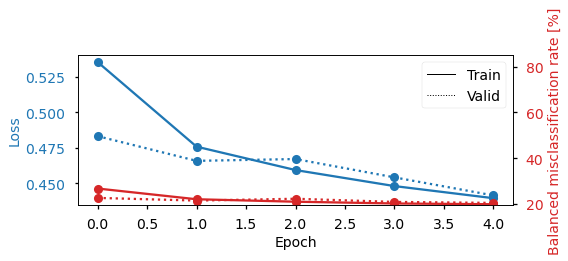

In [154]:
# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(net.history.to_list())
df[['train_mis_clf', 'valid_mis_clf']] = 100 - df[
    ['train_bal_acc', 'valid_bal_acc']] * 100

# get percent of misclass for better visual comparison to loss
plt.style.use('seaborn-talk')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False,
    fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_mis_clf', 'valid_mis_clf']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel('Balanced misclassification rate [%]', color='tab:red',
               fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel('Epoch', fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

In [155]:
embds = net.transform(valid_set)[::2]

In [156]:
sleep_stages = [x[1] for x in BaseConcatDataset([splitted[s] for s in valid_subjects])]

Text(0.5, 1.0, 'PCA of self-supervised embeddings according to sleep stages')

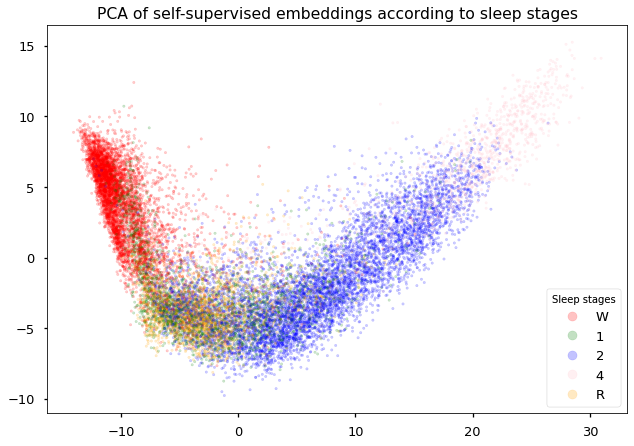

In [215]:
pca = PCA(2)
pca_embds = pca.fit_transform(embds)

scatter = plt.scatter(pca_embds[:,0], pca_embds[:,1], c=sleep_stages, cmap=sleep_cmap, alpha=0.2, s=6)
legend = plt.legend(*scatter.legend_elements(prop="colors"),
                    loc="lower right", title="Sleep stages")
for i in range(len(legend.get_texts())):
    legend.get_texts()[i].set_text(reverse_mapping[i])
plt.gca().add_artist(legend)
plt.title("PCA of self-supervised embeddings according to sleep stages")

Text(0.5, 1.0, 'TSNE of self-supervised embeddings according to sleep stages')

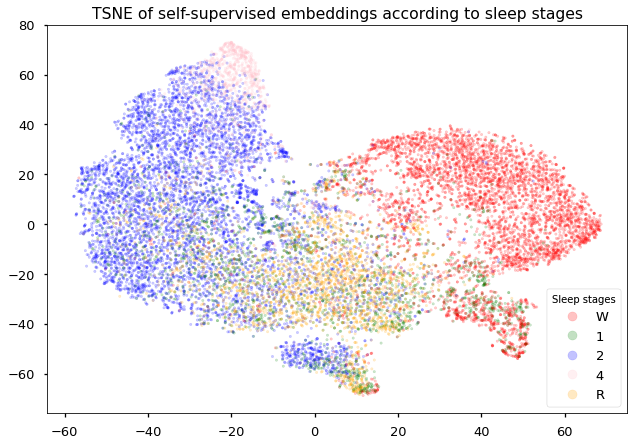

In [216]:
tsne = TSNE(2, n_jobs=-1)
tsne_embds = tsne.fit_transform(embds)

scatter = plt.scatter(tsne_embds[:,0], tsne_embds[:,1], c=sleep_stages, cmap=sleep_cmap, alpha=0.2, s=6)
legend = plt.legend(*scatter.legend_elements(prop="colors"),
                    loc="lower right", title="Sleep stages")
for i in range(len(legend.get_texts())):
    legend.get_texts()[i].set_text(reverse_mapping[i])
plt.gca().add_artist(legend)
plt.title('TSNE of self-supervised embeddings according to sleep stages')

In [178]:
ages = [i for s in valid_subjects for i in [info[info['subject'] == int(s)]['age'].iloc[0]]*len(splitted[s])]

Text(0.5, 1.0, 'PCA of self-supervised embeddings according to age')

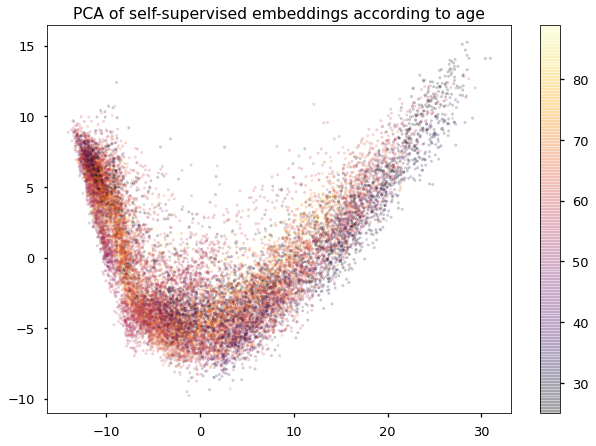

In [217]:
plt.scatter(pca_embds[:,0], pca_embds[:,1], c=ages, alpha=0.2, s=6, cmap=plt.get_cmap('inferno'))
plt.colorbar()
plt.title('PCA of self-supervised embeddings according to age')

Text(0.5, 1.0, 'TSNE of self-supervised embeddings according to age')

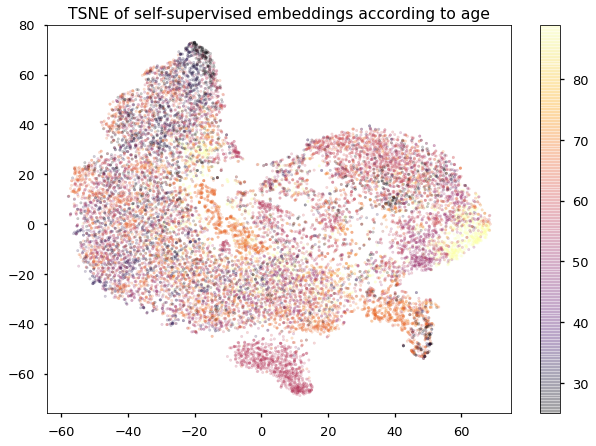

In [218]:
plt.scatter(tsne_embds[:,0], tsne_embds[:,1], c=ages, alpha=0.2, s=6, cmap=plt.get_cmap('inferno'))
plt.colorbar()
plt.title('TSNE of self-supervised embeddings according to age')

In [190]:
subject = [int(i) for s in valid_subjects for i in [s]*len(splitted[s])]
new_cmap = rand_cmap(max(subject), type='bright', first_color_black=True, last_color_black=False, verbose=False)

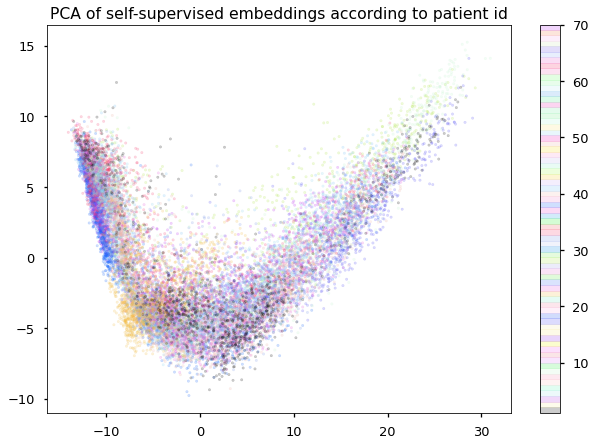

In [221]:
plt.scatter(pca_embds[:,0], pca_embds[:,1], c=subject, alpha=0.2, s=6, cmap=new_cmap)
plt.colorbar()
plt.title('PCA of self-supervised embeddings according to patient id')
plt.show()

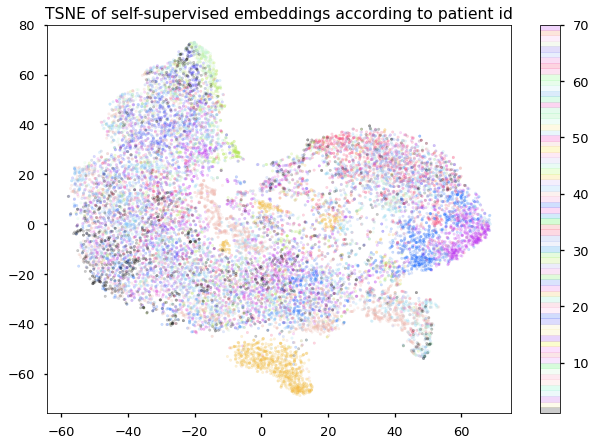

In [222]:
plt.scatter(tsne_embds[:,0], tsne_embds[:,1], c=subject, alpha=0.2, s=6, cmap=new_cmap)
plt.colorbar()
plt.title('TSNE of self-supervised embeddings according to patient id')
plt.show()

# SimpleSleepNet

In [56]:
class MultipleWindowsDataset(BaseConcatDataset):
    """
    ----------
    list_of_ds: list
        list of BaseDataset, BaseConcatDataset or WindowsDataset
    """
    def __init__(self, list_of_ds, number_of_windows=10, training=True):
        super(MultipleWindowsDataset, self).__init__(list_of_ds)
        self.number_of_windows = number_of_windows
        self.training = training
        
    def __len__(self):
        if self.training:
            return super().__len__() // self.number_of_windows
        else:
            return super().__len__()
    
    def __getitem__(self, idx):
        if self.training:
            idx = idx * self.number_of_windows + np.random.randint(0, self.number_of_windows)

        if idx < 0:
            if -idx > len(self):
                raise ValueError("absolute value of index should not exceed dataset length")
            idx = len(self) + idx
        dataset_idx = bisect.bisect_right(self.cumulative_sizes, idx)
        if dataset_idx == 0:
            center_idx = idx
        else:
            center_idx = idx - self.cumulative_sizes[dataset_idx - 1]
            
        center_crop = center_idx % self.number_of_windows
                                                     
        dataset_size = len(self.datasets[dataset_idx])
        
        if center_idx < self.number_of_windows // 2:
            center_idx = self.number_of_windows // 2
        elif center_idx > dataset_size - self.number_of_windows // 2 - 1:
            center_idx = dataset_size - self.number_of_windows // 2 - 1

        start_idx = center_idx - self.number_of_windows // 2
        end_idx = center_idx + self.number_of_windows // 2
        if end_idx == start_idx:
            end_idx += 1
    
        windows = []
        labels = []
        #pos = []
        for i in range(start_idx, end_idx):
            windows.append(self.datasets[dataset_idx][i][0])
            labels.append(self.datasets[dataset_idx][i][1])
            #pos.append(i)
        
        X = np.array(windows)
        y = np.array(labels)
        if self.training:
            return X, y
        else:
            return X, y[center_crop], [center_crop]

In [57]:
class SimpleSleepStagerChambon2018(nn.Module):
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25, apply_batch_norm=False):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        self.n_classes = n_classes
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        batch_norm = nn.BatchNorm2d if apply_batch_norm else nn.Identity

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.gru1 = nn.GRU(len_last_layer, len_last_layer // 2, batch_first=True, bidirectional=True)
        self.skip_gru1 = nn.Linear(len_last_layer, len_last_layer)
        self.gru2 = nn.GRU(len_last_layer, len_last_layer // 2, batch_first=True, bidirectional=True)
        self.skip_gru2 = nn.Linear(len_last_layer, len_last_layer)

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, data):
        """Forward pass.
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        n_windows = data[1]
        x = data[0]

        n_batch, n_channels, n_times = x.shape
        x = x.unsqueeze(1)

        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)

        x = x.view(n_batch // n_windows, n_windows, -1)
        
        x_gru, _ = self.gru1(x)
        x_skip = self.skip_gru1(x)
        x = x_gru + x_skip
        
        x_gru, _ = self.gru2(x)
        x_skip = self.skip_gru2(x)
        x = x_gru + x_skip

        x = self.fc(x)
        
        if False: #not self.training:
            center_pos = data[2]
            x = x[torch.arange(x.size(0)), center_pos, :]
        
        return x.view(-1, self.n_classes) #.transpose(1, 2)

In [82]:
model = SimpleSleepStagerChambon2018(n_channels=nb_channels, sfreq=sfreq, dropout=p_dropout)

In [59]:
trainwindow_set = MultipleWindowsDataset([splitted[s] for s in train_subjects], number_of_windows=20)
validwindow_set = MultipleWindowsDataset([splitted[s] for s in valid_subjects], number_of_windows=20, training=True)

In [83]:
model

SimpleSleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): Identity()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (5): Identity()
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
  )
  (gru1): GRU(320, 160, batch_first=True, bidirectional=True)
  (skip_gru1): Linear(in_features=320, out_features=320, bias=True)
  (gru2): GRU(320, 160, batch_first=True, bidirectional=True)
  (skip_gru2): Linear(in_features=320, out_features=320, bias=True)
  (fc): Sequential(
    (0): Dropout(p=0.7, inplace=False)
    (1): Linear(in_features=320, out_features=5, bias=True)
  )
)

In [84]:
# Train using a GPU if possible
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
set_random_seeds(seed=0, cuda=cuda)

model.to(device)


#Hyperparams
lr = 5e-4
batch_size = 8
n_epochs = 10

train_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bal_acc',
    lower_is_better=False)
valid_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bal_acc',
    lower_is_better=False)
callbacks = [('train_bal_acc', train_bal_acc),
             ('valid_bal_acc', valid_bal_acc),
             ('progress_bar', ProgressBar())]

def collate_multiple_windows_train(batch):
    data = np.array([item[0] for item in batch])
    n_batch, n_windows, n_channels, n_time = data.shape
    data = data.reshape(n_batch*n_windows, n_channels, n_time)
    data = torch.FloatTensor(data)
    target = np.array([item[1] for item in batch]).flatten()
    target = torch.LongTensor(target)
    return (data, n_windows), target

def collate_multiple_windows_val(batch):
    data = np.array([item[0] for item in batch])
    n_batch, n_windows, n_channels, n_time = data.shape
    data = data.reshape(n_batch*n_windows, n_channels, n_time)
    data = torch.FloatTensor(data)
    target = np.array([item[1] for item in batch]).flatten()
    target = torch.LongTensor(target)
    center_pos = torch.LongTensor([pos for item in batch for pos in item[2]])
    return (data, n_windows, center_pos), target

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(validwindow_set),  # using valid_set for validation
    iterator_train__collate_fn=collate_multiple_windows_train,
    iterator_valid__collate_fn=collate_multiple_windows_train,
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device,
    verbose=1
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(trainwindow_set, y=None, epochs=n_epochs)

  epoch    train_bal_acc    train_loss    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  ---------------  ------------  -------
      1           0.5887        0.7373           0.6513        0.6894  71.7733


      2           0.6531        0.6361           0.6221        0.6660  72.7756


      3           0.6669        0.6116           0.6459        0.6838  72.4825


      4           0.6753        0.5940           0.6384        0.7139  73.7221


      5           0.6855        0.5827           0.6606        0.6861  73.1535


      6           0.6882        0.5735           0.6115        0.6911  78.3945


      7           0.6941        0.5679           0.5950        0.6914  73.8567


      8           0.6948        0.5615           0.6165        0.6869  73.9268


      9           0.6993        0.5573           0.6357        0.6893  76.0004


     10           0.6993        0.5503           0.6436        0.7084  74.8856


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=SimpleSleepStagerChambon2018(
    (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
    (feature_extractor): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (1): Identity()
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (5): Identity()
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    )
    (gru1): GRU(320, 160, batch_first=True, bidirectional=True)
    (skip_gru1): Linear(in_features=320, out_features=320, bias=True)
    (gru2): GRU(320, 160, batch_first=True, bidirectional=True)
    (skip_gru2): Linear(in_features=320, out_features=320, bias=True)
    (fc): Sequential(
      (0): Dropout(p=0.7, inplace=False)
      (1): Linear(in_featur

In [85]:
for nb in [1, 2, 10, 20, 40, 50]:
    testwindow_set = MultipleWindowsDataset([splitted[s] for s in valid_subjects], number_of_windows=nb, training=True)
    y_pred = clf.predict(testwindow_set)
    y = np.array([item[1] for item in testwindow_set]).flatten()
    print(nb, np.sum(y==y_pred) / len(y))

1 0.7527449099243151
2 0.750666240272892
10 0.7220682302771855
20 0.679317697228145
40 0.6431236673773987
50 0.6288


In [71]:
clf.partial_fit(trainwindow_set, y=None, epochs=10)

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=SimpleSleepStagerChambon2018(
    (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
    (feature_extractor): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (1): Identity()
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (5): Identity()
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    )
    (gru1): GRU(320, 160, batch_first=True, bidirectional=True)
    (skip_gru1): Linear(in_features=320, out_features=320, bias=True)
    (gru2): GRU(320, 160, batch_first=True, bidirectional=True)
    (skip_gru2): Linear(in_features=320, out_features=320, bias=True)
    (fc): Sequential(
      (0): Dropout(p=0.7, inplace=False)
      (1): Linear(in_featur

In [78]:
model2 = SleepStagerChambon2018(n_channels=nb_channels, sfreq=sfreq, dropout=p_dropout)

In [79]:
trainwindow_set = MultipleWindowsDataset([splitted[s] for s in train_subjects], number_of_windows=1)
validwindow_set = MultipleWindowsDataset([splitted[s] for s in valid_subjects], number_of_windows=1, training=True)

In [80]:
# Train using a GPU if possible
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
set_random_seeds(seed=0, cuda=cuda)

model2.to(device)


#Hyperparams
lr = 5e-4
batch_size = 8
n_epochs = 10

train_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bal_acc',
    lower_is_better=False)
valid_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bal_acc',
    lower_is_better=False)
callbacks = [('train_bal_acc', train_bal_acc),
             ('valid_bal_acc', valid_bal_acc),
             ('progress_bar', ProgressBar())]

def collate(batch):
    data = np.array([item[0] for item in batch])
    n_batch, n_windows, n_channels, n_time = data.shape
    data = data.reshape(n_batch*n_windows, n_channels, n_time)
    data = torch.FloatTensor(data)
    target = np.array([item[1] for item in batch]).flatten()
    target = torch.LongTensor(target)
    return data, target

clf2 = EEGClassifier(
    model2,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(validwindow_set),  # using valid_set for validation
    iterator_train__collate_fn=collate,
    iterator_valid__collate_fn=collate,
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device,
    verbose=1
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf2.fit(trainwindow_set, y=None, epochs=n_epochs)

  epoch    train_bal_acc    train_loss    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  ---------------  ------------  -------
      1           0.5263        0.8005           0.6129        0.6470  36.4905


      2           0.6211        0.6764           0.6205        0.6485  35.8095


      3           0.6348        0.6539           0.5999        0.6521  37.9821


      4           0.6451        0.6394           0.6113        0.6579  37.3675


      5           0.6457        0.6343           0.6214        0.6442  38.2864


      6           0.6510        0.6288           0.6025        0.6468  36.3031


      7           0.6560        0.6224           0.6274        0.6480  37.3370


      8           0.6558        0.6211           0.6009        0.6613  39.0692


      9           0.6569        0.6156           0.6151        0.6565  41.2733


     10           0.6603        0.6134           0.6443        0.6497  38.1978


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=SleepStagerChambon2018(
    (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
    (feature_extractor): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Dropout(p=0.7, inplace=False)
      (1): Linear(in_features=320, out_features=5, bias=True)
    )
  ),
)

In [ ]:
clf2.partial_fit(trainwindow_set, y=None, epochs=10)

In [81]:
for nb in [1, 2, 10, 20, 40, 50]:
    testwindow_set = MultipleWindowsDataset([splitted[s] for s in valid_subjects], number_of_windows=nb, training=True)
    y_pred = clf2.predict(testwindow_set)
    y = np.array([item[1] for item in testwindow_set]).flatten()
    print(nb, np.sum(y==y_pred) / len(y))

1 0.7661763138258182
2 0.7542372881355932
10 0.7161513859275054
20 0.6852345415778252
40 0.6358742004264393
50 0.6297066666666666


# TCC Loss

In [74]:
import torch.nn as nn
from torch.nn import functional as F


class AlignementModule(nn.Module):
    def __init__(self, similarity_type="l2", temperature=1.):
        super(AlignementModule, self).__init__()
        
        self.similarity_type = similarity_type
        self.temperature = temperature
    
    def forward(self, embs, steps=None, seq_lens=None):
        
        batch_size = embs.shape[0]
        num_steps = embs.shape[1]

        if steps is None:
            steps = torch.arange(num_steps).unsqueeze(0).expand((batch_size, -1)).to(embs.device)
        if seq_lens is None:
            seq_lens = torch.LongTensor([num_steps]*batch_size).to(embs.device)

        labels_list = []
        logits_list = []
        steps_list = []
        seq_lens_list = []

        for i in range(batch_size):
            for j in range(batch_size):
                # We do not align the sequence with itself.
                if i != j:
                    logits, labels = self.align_pair_of_sequences(embs[i],
                                                                  embs[j],
                                                                  self.similarity_type,
                                                                  self.temperature)
                    logits_list.append(logits)
                    labels_list.append(labels)
                    steps_list.append(steps[i:i+1].expand([num_steps, -1]))
                    seq_lens_list.append(seq_lens[i:i+1].expand([num_steps]))

        logits = torch.cat(logits_list)
        labels = torch.cat(labels_list)
        steps = torch.cat(steps_list)
        seq_lens = torch.cat(seq_lens_list)
        
        return logits, embs, labels, steps, seq_lens
    
    def pairwise_l2_distance(self, x, y=None):
        x_norm = (x**2).sum(1).view(-1, 1)
        if y is not None:
            y_t = torch.transpose(y, 0, 1)
            y_norm = (y**2).sum(1).view(1, -1)
        else:
            y_t = torch.transpose(x, 0, 1)
            y_norm = x_norm.view(1, -1)

        dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
        # Ensure diagonal is zero if x=y
        if y is None:
            dist = dist - torch.diag(dist.diag)
        return torch.clamp(dist, 0.0, np.inf)


    def get_scaled_similarity(self, embs1, embs2, similarity_type, temperature):
        channels = float(embs1.shape[1])
        # Go for embs1 to embs2.
        if similarity_type == 'cosine':
            similarity = torch.matmul(embs1, embs2.T)
        elif similarity_type == 'l2':
            similarity = -1.0 * self.pairwise_l2_distance(embs1, embs2)
        else:
            raise ValueError('similarity_type can either be l2 or cosine.')

        # Scale the distance  by number of channels. This normalization helps with
        # optimization.
        similarity /= channels
        # Scale the distance by a temperature that helps with how soft/hard the
        # alignment should be.
        similarity /= temperature

        return similarity


    def align_pair_of_sequences(self, embs1, embs2, similarity_type, temperature):
        max_num_steps = embs1.shape[0]

        # Find distances between embs1 and embs2.
        sim_12 = self.get_scaled_similarity(embs1, embs2, similarity_type, temperature)
        # Softmax the distance.
        softmaxed_sim_12 = F.softmax(sim_12, dim=1)

        # Calculate soft-nearest neighbors.
        nn_embs = torch.matmul(softmaxed_sim_12, embs2)

        # Find distances between nn_embs and embs1.
        sim_21 = self.get_scaled_similarity(nn_embs, embs1, similarity_type, temperature)

        logits = sim_21
        labels = torch.arange(max_num_steps).to(sim_21.device)

        return logits, labels


class TCCLoss(nn.Module):
    def __init__(self, variance_lambda, loss_type='var', normalize_indices=True, label_smoothing=0.):
        super(TCCLoss, self).__init__()
        
        self.variance_lambda = variance_lambda
        self.loss_type = loss_type
        self.normalize_indices = normalize_indices
        self.label_smoothing = label_smoothing
    
    def forward(self, inputs, y=None):
        logits, embs, labels, steps, seq_lens = inputs
        num_steps = steps.shape[1]
        
        classification_loss = torch.mean(F.cross_entropy(logits, labels))
        
        seq_lens = seq_lens.float()
        
        if self.normalize_indices:
            tile_seq_lens = seq_lens.unsqueeze(1).expand([-1, num_steps])
            steps = steps / tile_seq_lens
        
        beta = F.softmax(logits, dim=1)
        true_time = torch.sum(steps * F.one_hot(labels), dim=1)
        pred_time = torch.sum(steps * beta, dim=1)

        if 'var' in self.loss_type:
            # Variance aware regression.
            pred_time_tiled = pred_time.unsqueeze(1).expand([-1, num_steps])

            pred_time_variance = torch.sum((steps - pred_time_tiled)**2 * beta, dim=1)

            # Using log of variance as it is numerically stabler.
            pred_time_log_var = torch.log(pred_time_variance + 1e-16)
            squared_error = (true_time - pred_time)**2
            regression_loss = torch.mean(torch.exp(-pred_time_log_var) * squared_error
                                + self.variance_lambda * pred_time_log_var)
        else:
            regression_loss = torch.mean(F.mse_loss(pred_time, true_time))

        return classification_loss + regression_loss

In [14]:
inputs = torch.FloatTensor(np.random.random(4*10*16).reshape(4,10,16))

am = AlignementModule(similarity_type="cosine", temperature=1.)
logits, embs, labels, steps, seq_lens = am(inputs)

tcc = TCCLoss(variance_lambda=0.1, loss_type='var')
loss = tcc((logits, embs, labels, steps, seq_lens))

In [15]:
class StackDataset(BaseConcatDataset):
    """A base class for concatenated datasets. Holds either mne.Raw or
    mne.Epoch in self.datasets and has a pandas DataFrame with additional
    description.
    Parameters
    ----------
    list_of_ds: list
        list of BaseDataset, BaseConcatDataset or WindowsDataset
    """
    def __init__(self, list_of_ds, size=None):
        super(StackDataset, self).__init__(list_of_ds)
        if size is None:
            self.size = min([len(dataset) for dataset in self.datasets])
        else:
            self.size = size
        
        self.indexes = [(d_ind, t_ind) for d_ind in range(len(self.datasets)) for t_ind in range(len(self.datasets[d_ind]) // self.size)]
    
    def __len__(self):
        return len(self.indexes)
    
    def __getitem__(self, index):
        index, t_index = self.indexes[index]
        X, y, crop_inds = zip(*[self.datasets[index][i] for i in range(len(self.datasets[index]))])
        X, y, crop_inds = np.array(X), np.array(y), np.array(crop_inds)
        X = X[t_index*self.size:(t_index+1)*self.size]
        y = y[t_index*self.size:(t_index+1)*self.size]
        crop_inds = crop_inds[t_index*self.size:(t_index+1)*self.size]
        return X, y  #,crop_inds

In [23]:
splitted = windows_dataset.split('subject')

valid_proportion = 0.2
subjects = list(splitted.keys())
np.random.shuffle(subjects)
train_subjects = subjects[int(len(subjects) * valid_proportion):]
valid_subjects = subjects[:int(len(subjects) * valid_proportion)]

train_set = StackDataset([splitted[s] for s in train_subjects], size=50)
valid_set = StackDataset([splitted[s] for s in valid_subjects], size=50)

In [16]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

class SplitMergeEmbeddings(nn.Module):
    """Split and merge"""
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        batch, time = x.shape[:2]
        other = x.shape[2:]
        x = x.view(batch * time, 1, *other)
        x = self.module(x)
        x = x.view(batch, time, x.shape[1])
        return x

In [25]:
nb_channels = 2
p_dropout = 0.2
device = "cuda"
#network = EncoderNet(nb_channels=nb_channels, p_dropout=p_dropout)

In [26]:
alignement_network = nn.Sequential(
    SplitMergeEmbeddings(network),
    AlignementModule())
alignement_network.to(device)

Sequential(
  (0): SplitMergeEmbeddings(
    (module): EncoderNet(
      (encoder): Sequential(
        (0): Conv2d(1, 32, kernel_size=(2, 50), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=(1, 6), stride=(1, 6), padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(32, 64, kernel_size=(1, 50), stride=(1, 1))
        (5): ReLU()
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): MaxPool2d(kernel_size=(1, 6), stride=(1, 6), padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(64, 128, kernel_size=(1, 50), stride=(1, 1))
        (9): ReLU()
        (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): MaxPool2d(kernel_size=(1, 6), stride=(1, 6), padding=0, dilation=1, ceil_mode=False)
        (12): AdaptiveAvgPool2d(output_size=1)
        (13): Flatten(start_d

In [28]:
# Train using a GPU if possible
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
set_random_seeds(seed=0, cuda=cuda)

# Hyperparameters
lr = 5e-4
nb_channels = 2
p_dropout = 0.2
batch_size = 30
nb_epochs = 500

# Skorch model creation

net = EEGTransformer(
    alignement_network,
    criterion=TCCLoss,
    criterion__variance_lambda=0.1,
    criterion__loss_type='var',
    optimizer=torch.optim.Adam,
    optimizer__lr=lr,
    train_split=predefined_split(valid_set),
    batch_size=batch_size,
    callbacks=[('progress_bar', ProgressBar())],
    device=device
)

# Training: `y` is None since it is already supplied in the dataset.
net.fit(train_set, y=None, epochs=nb_epochs)

RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at aten/src/ATen/CPUType.cpp:1677 [kernel]
CUDA: registered at aten/src/ATen/CUDAType.cpp:2949 [kernel]
QuantizedCPU: registered at aten/src/ATen/QuantizedCPUType.cpp:294 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:7962 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:7962 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:7962 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:7962 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:7962 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:7962 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:7962 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_2.cpp:9386 [kernel]
Autocast: registered at ../aten/src/ATen/autocast_mode.cpp:257 [kernel]
Batched: registered at ../aten/src/ATen/BatchingRegistrations.cpp:482 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


In [38]:
embds_night = net.transform(valid_set)
embds = embds_night.reshape(-1, 128)

In [39]:
def get_nn(embs, query_emb):
    dist = np.linalg.norm(embs - query_emb, axis=1)
    assert len(dist) == len(embs)
    return np.argmin(dist), np.min(dist)


def align(query_feats, candidate_feats, use_dtw=False):
    """Align videos based on nearest neighbor or dynamic time warping."""
    if use_dtw:
        _, _, _, path = dtw(query_feats, candidate_feats, dist=dist_fn)
        _, uix = np.unique(path[0], return_index=True)
        nns = path[1][uix]
    else:
        nns = []
        for i in range(len(query_feats)):
            nn_frame_id, _ = get_nn(candidate_feats, query_feats[i])
            nns.append(nn_frame_id)
    return nns

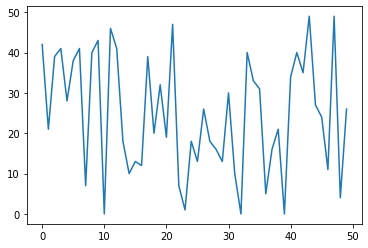

In [42]:
plt.plot(align(embds_night[0], embds_night[100]))

In [165]:
del dataloader
import gc;gc.collect()
torch.cuda.empty_cache()

In [24]:
sleep_stages = np.concatenate([x[1] for x in valid_set])

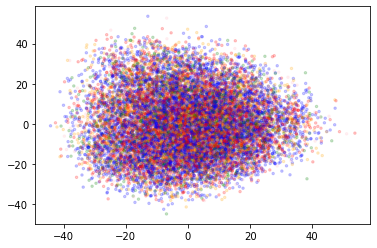

In [25]:
pca = PCA(2)
pca_embds = pca.fit_transform(embds)

plt.scatter(pca_embds[:,0], pca_embds[:,1], c=[['r', 'g', 'b', 'pink', 'orange'][i] for i in sleep_stages], alpha=0.2, s=6)

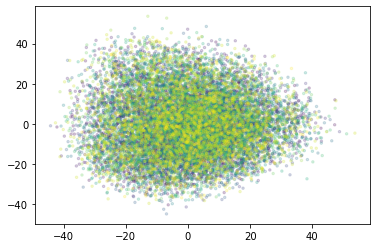

In [26]:
plt.scatter(pca_embds[:,0], pca_embds[:,1], c=[i for i in range(len(valid_set.datasets)) for _ in range(len(valid_set.datasets[i]) // 50 * 50)], alpha=0.2, s=6)

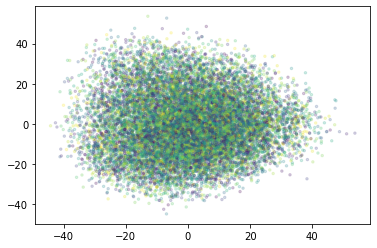

In [28]:
plt.scatter(pca_embds[:,0], pca_embds[:,1], c=[j%50 for i in range(len(valid_set.datasets)) for j in range(len(valid_set.datasets[i]) // 50 * 50)], alpha=0.2, s=6)

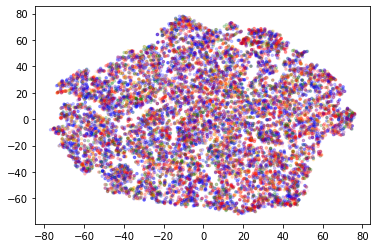

In [114]:
tsne = TSNE(2, n_jobs=-1)
tsne_embds = tsne.fit_transform(embds)

plt.scatter(tsne_embds[:,0], tsne_embds[:,1], c=[['r', 'g', 'b', 'pink', 'orange'][i] for i in sleep_stages], alpha=0.2, s=6)

# AdaIN

In [13]:
class AutoEncoderDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super(AutoEncoderDataset, self).__init__()
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        X, y, _ = self.dataset[index]
        return X, X

In [14]:
train_set = AutoEncoderDataset(BaseConcatDataset([splitted[s] for s in train_subjects]))
valid_set = AutoEncoderDataset(BaseConcatDataset([splitted[s] for s in valid_subjects]))

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class InstanceNorm(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps

    def calc_mean_std(self, x, mask=None):
        B, C = x.shape[:2]

        mn = x.view(B, C, -1).mean(-1)
        sd = (x.view(B, C, -1).var(-1) + self.eps).sqrt()
        mn = mn.view(B, C, *((len(x.shape) - 2) * [1]))
        sd = sd.view(B, C, *((len(x.shape) - 2) * [1]))
        
        return mn, sd


    def forward(self, x, return_mean_std=False):
        mean, std = self.calc_mean_std(x)
        x = (x - mean) / std
        if return_mean_std:
            return x, mean, std
        else:
            return x


class ConvNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, groups=1, bias=True, w_init_gain='linear', padding_mode='zeros', sn=False):
        super(ConvNorm, self).__init__()
        if padding is None:
            if type(kernel_size) is tuple:
                assert(np.all(k % 2 == 1 for k in kernel_size))
                padding = [int(dilation * (k - 1) / 2) for k in kernel_size]
            else:
                assert(kernel_size % 2 == 1)
                padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    groups=groups,
                                    bias=bias, padding_mode=padding_mode)
        if sn:
            self.conv = nn.utils.spectral_norm(self.conv)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal

class ConvNorm2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear', padding_mode='zeros'):
        super().__init__()
        if padding is None:
            if type(kernel_size) is tuple:
                padding = []
                for k in kernel_size:
                    assert(k % 2 == 1)
                    p = int(dilation * (k - 1) / 2)
                    padding.append(p)
                padding = tuple(padding)
            else:
                assert(kernel_size % 2 == 1)
                padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv2d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias, padding_mode=padding_mode)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal


class EncConvBlock(nn.Module):
    def __init__(self, c_in, c_h, subsample=1):
        super().__init__()
        self.seq = nn.Sequential(
                ConvNorm(c_in, c_h, kernel_size=3, stride=1),
                nn.BatchNorm1d(c_h),
                nn.LeakyReLU(),
                ConvNorm(c_h, c_in, kernel_size=3, stride=subsample),
                )
        self.subsample = subsample
    def forward(self, x):
        y = self.seq(x)
        if self.subsample > 1:
            x = F.avg_pool1d(x, kernel_size=self.subsample)
        return x + y


class DecConvBlock(nn.Module):
    def __init__(self, c_in, c_h, c_out, upsample=1):
        super().__init__()
        self.dec_block = nn.Sequential(
                ConvNorm(c_in, c_h, kernel_size=3, stride=1),
                nn.BatchNorm1d(c_h),
                nn.LeakyReLU(),
                ConvNorm(c_h, c_in, kernel_size=3),
                )
        self.gen_block = nn.Sequential(
                ConvNorm(c_in, c_h, kernel_size=3, stride=1),
                nn.BatchNorm1d(c_h),
                nn.LeakyReLU(),
                ConvNorm(c_h, c_in, kernel_size=3),
                )
        self.upsample = upsample
    def forward(self, x):
        y = self.dec_block(x)
        if self.upsample >  1:
            x = F.interpolate(x, scale_factor=self.upsample)
            y = F.interpolate(y, scale_factor=self.upsample)
        y = y + self.gen_block(y)
        return x + y


# ====================================
#  Model
# ====================================
class Encoder(nn.Module):
    def __init__(
        self, c_in, c_out, channels,
        n_conv_blocks, c_h, subsample
    ):
        super().__init__()
        self.conv2d_blocks = nn.ModuleList([
            ConvNorm2d(channels, 8),
            ConvNorm2d(8, 8),
            ConvNorm2d(8, 1),
            nn.BatchNorm2d(1), nn.LeakyReLU(),
        ])
        # 1d Conv blocks
        self.inorm = InstanceNorm()
        self.conv1d_first = ConvNorm(c_in * 1, c_h)
        self.conv1d_blocks = nn.ModuleList([
            EncConvBlock(c_h, c_h, subsample=sub) for _, sub in zip(range(n_conv_blocks), subsample)
            ])
        self.out_layer = ConvNorm(c_h, c_out)

    def forward(self, x):

        y = x
        for block in self.conv2d_blocks:
            y = block(y)
        y = y.squeeze(1)
        y = self.conv1d_first(y)

        mns = []
        sds = []
        
        for block in self.conv1d_blocks:
            y = block(y)
            y, mn, sd = self.inorm(y, return_mean_std=True)
            mns.append(mn)
            sds.append(sd)

        y = self.out_layer(y)

        return y, mns, sds


class Decoder(nn.Module):
    def __init__(
        self, c_in, c_h, channels, c_out, 
        n_conv_blocks, upsample
    ):
        super().__init__()
        self.in_layer = ConvNorm(c_in, c_h, kernel_size=3)
        self.act = nn.LeakyReLU()

        self.conv_blocks = nn.ModuleList([
            DecConvBlock(c_h, c_h, c_h, upsample=up) for _, up in zip(range(n_conv_blocks), upsample)
        ])

        self.inorm = InstanceNorm()
        self.rnn = nn.GRU(c_h, c_h, 2)
        self.out_layer = nn.Linear(c_h, c_out * channels)
        self.out_conv = nn.ModuleList([
            ConvNorm2d(channels, channels),
            ConvNorm2d(channels, channels)
        ])
        self.channels = channels
        self.c_out = c_out

    def forward(self, enc, cond, return_c=False, return_s=False):
        y1, _, _ = enc
        y2, mns, sds = cond
        mn, sd = self.inorm.calc_mean_std(y2)
        c = y1
        c_affine = c * sd + mn
        
        batch = y1.shape[0]

        y = self.in_layer(c_affine)
        y = self.act(y)

        for i, (block, mn, sd) in enumerate(zip(self.conv_blocks, mns, sds)):
            y = block(y)
            y = self.inorm(y)
            y = y * sd + mn

        y = torch.cat((mn, y), dim=2)
        y = y.transpose(1,2)
        y, _ = self.rnn(y)
        y = y[:,1:,:]
        y = self.out_layer(y)
        y = y.transpose(1,2)
        y = y.view(batch, self.channels, self.c_out, y.shape[-1])
        for block in self.out_conv:
            y = block(y)
        if return_c:
            return y, c
        elif return_s:
            mn = torch.cat(mns, -2)
            sd = torch.cat(sds, -2)
            s = mn * sd
            return y, s
        else:
            return y

class VariantSigmoid(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        y = 1 / (1+torch.exp(-self.alpha*x))
        return y

class NoneAct(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x


class Activation(nn.Module):
    dct = {
        'none': NoneAct,
        'sigmoid': VariantSigmoid,
        'tanh': nn.Tanh
    }
    def __init__(self, act, params=None):
        super().__init__()
        self.act = Activation.dct[act](**params)

    def forward(self, x):
        return self.act(x)

class Model(nn.Module):
    def __init__(self, encoder_params, decoder_params, activation_params):
        super().__init__()

        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        self.act = Activation(**activation_params)

    def forward(self, x, x_cond=None):

        len_x = x.size(-1)
        
        if x_cond is None:
            x_cond = torch.cat((x[...,len_x//2:], x[...,:len_x//2]), axis=-1)
           
        original_source_len = x.size(-1)
        original_target_len = x_cond.size(-1)
            
        if False: # not self.training:
            if original_source_len % 8 != 0:
                x = F.pad(x, (0, 8 - original_source_len % 8), mode='reflect')
            if original_target_len % 8 != 0:
                x_cond = F.pad(x_cond, (0, 8 - original_target_len % 8), mode='reflect')

        # x, x_cond = x[:,None,:,:], x_cond[:,None,:,:]

        enc, mns_enc, sds_enc = self.encoder(x)
        cond, mns_cond, sds_cond = self.encoder(x_cond)

        enc = (self.act(enc), mns_enc, sds_enc)
        cond = (self.act(cond), mns_cond, sds_cond)

        y = self.decoder(enc, cond)

        if False: #not self.training:
            y = y[...,:original_source_len]
            x = x[...,:original_source_len]

        return y, enc, x

In [16]:
class STFT(nn.Module):
    def __init__(self, n_fft, hop_length=None, win_length=None, window=None, filter_f=None):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = int(np.floor(n_fft / 4)) if hop_length is None else hop_length
        self.win_length = n_fft if win_length is None else win_length
        self.window = nn.Parameter(torch.hann_window(n_fft) if (
            window is None and win_length is None) else torch.hann_window(win_length) if (
                win_length is not None and window is None) else window, requires_grad=False)
        self.filter_f = filter_f
        
    def forward(self, X):
        batch, n_channels = X.shape[:2]
        X = X.view(batch * n_channels, *X.shape[2:])
        stft_X = torch.stft(X,
                            n_fft=self.n_fft,
                            hop_length=self.hop_length,
                            win_length=self.win_length,
                            window=self.window)
        if self.filter_f is not None:
            stft_X = stft_X[:, :self.filter_f]
        
        stft_X = stft_X.permute(0, 3, 1, 2).contiguous()
        stft_X = stft_X.view(batch, 2 * n_channels, *stft_X.shape[2:])
        
        return stft_X

class ISTFT(nn.Module):
    def __init__(self, n_fft, hop_length=None, win_length=None, window=None, filter_f=None):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = int(np.floor(n_fft / 4)) if hop_length is None else hop_length
        self.win_length = n_fft if win_length is None else win_length
        self.window = nn.Parameter(torch.hann_window(n_fft) if (
            window is None and win_length is None) else torch.hann_window(win_length) if (
                win_length is not None and window is None) else window, requires_grad=False)
        self.filter_f = filter_f
        
    def forward(self, stft_X):
        batch = stft_X.shape[0]
        n_channels = stft_X.shape[1] // 2
        stft_X = stft_X.view(batch * n_channels, 2, *stft_X.shape[2:])
        stft_X = stft_X.permute(0, 2, 3, 1)
        
        stft_X = F.pad(stft_X, (0, 0, 0, 0, 0, int(self.n_fft / 2 + 1) - self.filter_f), value=0.)

        X = torch.istft(stft_X,
                        n_fft=self.n_fft,
                        hop_length=self.hop_length,
                        win_length=self.win_length,
                        window=self.window)
        
        X = X.view(batch, n_channels, *X.shape[1:])
        
        return X

torch.Size([4, 20, 201])


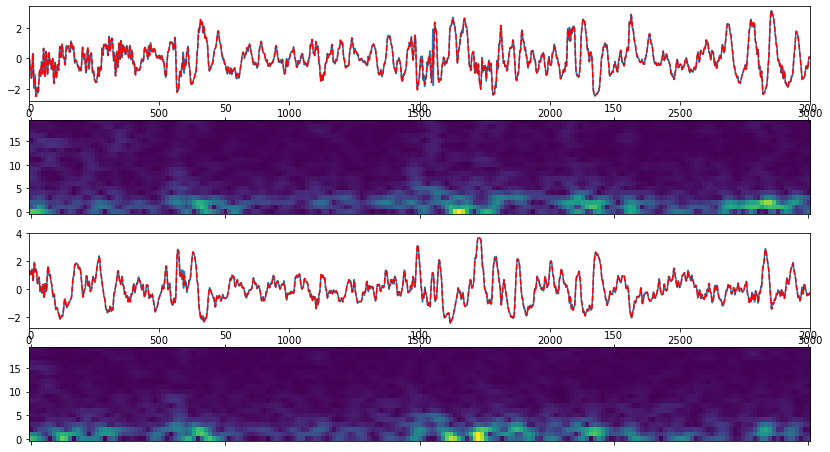

In [17]:
n_fft = 126
filter_f = 20
stft = STFT(n_fft=n_fft, hop_length=int(np.floor(n_fft / 8)), win_length=int(n_fft), filter_f=filter_f)
istft = ISTFT(n_fft=n_fft, hop_length=int(np.floor(n_fft / 8)), win_length=int(n_fft), filter_f=filter_f)

x = train_set[100][0]
spec = stft(torch.FloatTensor([x]))[0]
x_rec = istft(spec[None])[0]

assert x.shape == x_rec.shape

print(spec.shape)

fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot(4, 1, 1)
ax1.plot(x[0])
ax1.plot(x_rec[0], 'r--')
ax1.set_xlim([0,len(x[0])])
ax2 = plt.subplot(4, 1, 2)
ax2.matshow((spec[0]**2 + spec[1]**2)**0.5, aspect="auto")
ax2.invert_yaxis()
ax3 = plt.subplot(4, 1, 3, sharex=ax1)
ax3.plot(x[1])
ax3.plot(x_rec[1], 'r--')
ax3.set_xlim([0,len(x[1])])
ax4 = plt.subplot(4, 1, 4, sharex=ax2)
ax4.matshow((spec[2]**2 + spec[3]**2)**0.5, aspect="auto")
ax4.invert_yaxis()

In [25]:
encoder_params = {
    'c_in': 20,
    'c_out': 5,
    'channels': 4,
    'n_conv_blocks': 6,
    'c_h': 256,
    'subsample': [1, 1, 1, 1, 1, 1]
}
decoder_params = {
    'c_in': 5,
    'c_out': 20,
    'channels': 4,
    'n_conv_blocks': 6,
    'c_h': 256,
    'upsample': [1, 1, 1, 1, 1, 1]
}
activation_params = {'act': 'sigmoid', 'params': {'alpha': 0.01}}
n_fft = 126
filter_f = 20

model = Model(encoder_params, decoder_params, activation_params)
model = nn.Sequential(
    STFT(n_fft=n_fft, hop_length=int(np.floor(n_fft / 8)), win_length=int(n_fft), filter_f=filter_f),  # Lambda(lambda x: x.permute(0,2,1)),
    model,
    # Lambda(lambda x: (x[0].permute(0,2,1), x[1])),
)

In [26]:
x = torch.rand(7, 2, 3000)

In [27]:
print("Input shape:", list(x.shape))
print("Spectrogram shape:", list(stft(x).shape))
print("Output shape:", list(y.shape if type(y) is not tuple else y[0].shape for y in model(x)))

Input shape: [7, 2, 3000]
Spectrogram shape: [7, 4, 20, 201]
Output shape: [torch.Size([7, 4, 20, 201]), torch.Size([7, 5, 201]), torch.Size([7, 4, 20, 201])]


In [28]:
class EEGTransformerRegressor(EEGRegressor, TransformerMixin):
    def __init__(self, *args, **kwargs):
        super(EEGTransformerRegressor, self).__init__(*args, **kwargs)
    
    def get_loss(self, y_pred, y_true, X, **kwargs):
        x_pred, _, x_true = y_pred
        return super().get_loss(x_pred, y_true=x_true, X=X, **kwargs)
    
    def transform(self, X):
        outs_emb, outs_mn, outs_sd = [], [], []
        for outs in self.forward_iter(X, training=False):
            outs = outs[1] if isinstance(outs, tuple) else outs
            outs_embs = outs[1][0]
            outs_mns = outs[1][1]
            outs_sds = outs[1][2]
            outs_emb.append(to_numpy(outs_embs))
            outs_mn.append(outs_mns)
            outs_sd.append(outs_sds)
        outs_emb = np.concatenate(outs_emb, 0)
        outs_mn = np.concatenate(outs_mn, 0)
        outs_sd = np.concatenate(outs_sd, 0)
        return outs_emb, outs_mn, outs_sd

In [29]:
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
set_random_seeds(seed=0, cuda=cuda)

# Hyperparameters
lr = 5e-4
batch_size = 100
nb_epochs = 500

reg = EEGTransformerRegressor(
    model,
    criterion=torch.nn.L1Loss,
    optimizer=torch.optim.Adam,
    optimizer__lr=lr,
    train_split=predefined_split(valid_set),
    batch_size=batch_size,
    callbacks=[('progress_bar', ProgressBar())],
    device=device
)

In [30]:
reg.fit(train_set, y=None, epochs=nb_epochs)

/home/theo/.conda/envs/mne/lib/python3.8/site-packages/torch/backends/cudnn/__init__.py:72: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(


  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.1017        3.8924  736.1933


      2        3.6890        3.7761  732.7587


      3        3.6673        3.7608  727.7710


      4        3.6582        3.7519  728.1838


      5        3.6558        3.7455  729.3797


      6        3.6510        3.7450  728.2196


      7        3.6451        3.7317  727.7659


      8        3.3780        3.3257  742.7568


      9        3.2392        3.3143  737.7755


     10        3.2249        3.3258  732.4520


<class '__main__.EEGTransformerRegressor'>[initialized](
  module_=Sequential(
    (0): STFT()
    (1): Model(
      (encoder): Encoder(
        (conv2d_blocks): ModuleList(
          (0): ConvNorm2d(
            (conv): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): ConvNorm2d(
            (conv): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): ConvNorm2d(
            (conv): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
          )
          (3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): LeakyReLU(negative_slope=0.01)
        )
        (inorm): InstanceNorm()
        (conv1d_first): ConvNorm(
          (conv): Conv1d(20, 256, kernel_size=(1,), stride=(1,))
        )
        (conv1d_blocks): ModuleList(
          (0): EncConvBlock(
            (seq): Sequential(
              (0): ConvNorm(
                (conv): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  

In [31]:
p = reg.predict(valid_set)

In [32]:
p.shape

(16821, 4, 20, 201)

In [35]:
reg.save_params(f_params='again_vc.pkl')

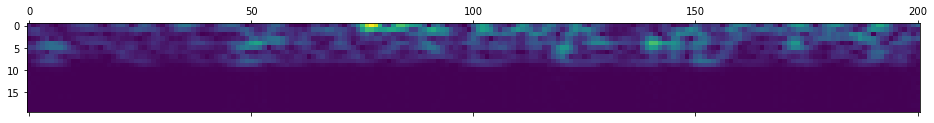

<Figure size 432x288 with 0 Axes>

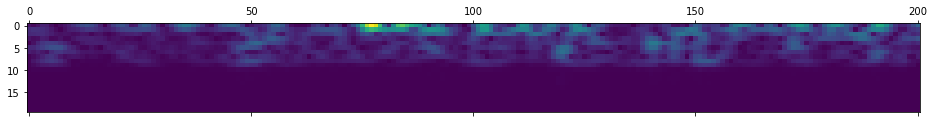

In [33]:
spec_p = (p[10].reshape(2, 2, 20, 201).transpose((0, 2, 3, 1))**2).sum(-1)**0.5
plt.matshow(spec_p[0])
plt.figure()
plt.matshow(spec_p[1])

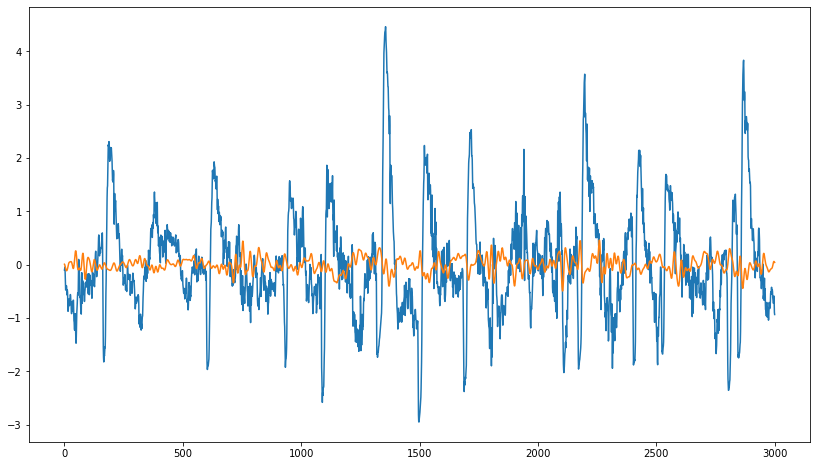

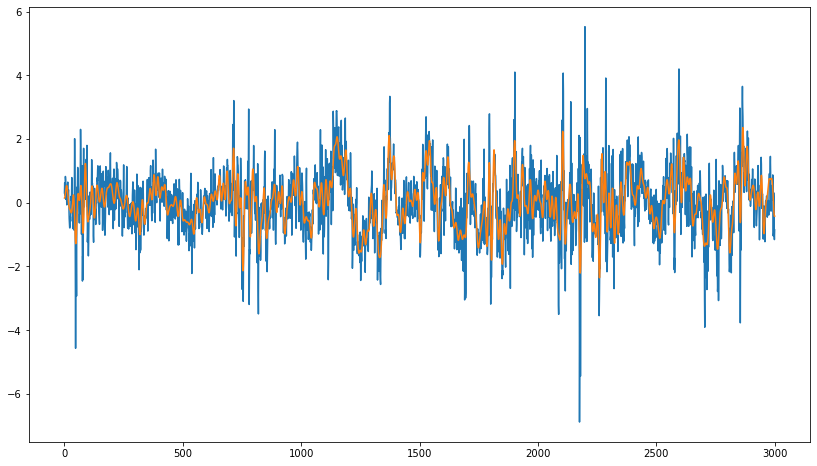

In [46]:
i = 10
plt.figure(figsize=(14,8))
plt.plot(valid_set[i][0][0])
plt.plot(istft(torch.FloatTensor(p[i][None]))[0][0])

plt.figure(figsize=(14,8))
plt.plot(valid_set[i][0][1])
plt.plot(istft(torch.FloatTensor(p[i][None]))[0][1])

In [36]:
sleep_stages = np.array([x[1] for x in BaseConcatDataset([splitted[s] for s in valid_subjects])])

In [37]:
embds, mns, sds = reg.transform(valid_set)
mns = np.array(mns)
sds = np.array(sds)

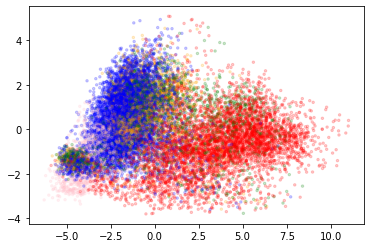

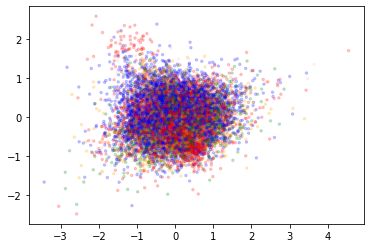

In [38]:
pca = PCA(4)
pca_embds = pca.fit_transform(embds.reshape(embds.shape[0], -1))

plt.scatter(pca_embds[:,0], pca_embds[:,1], c=[['r', 'g', 'b', 'pink', 'orange'][i] for i in sleep_stages], alpha=0.2, s=6)
plt.figure()
plt.scatter(pca_embds[:,2], pca_embds[:,3], c=[['r', 'g', 'b', 'pink', 'orange'][i] for i in sleep_stages], alpha=0.2, s=6)

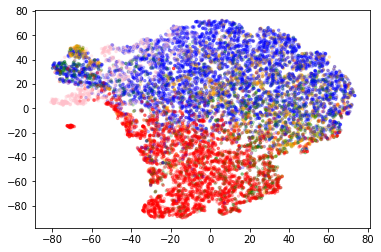

In [39]:
tsne = TSNE(2, n_jobs=-1)
tsne_embds = tsne.fit_transform(embds.reshape(embds.shape[0], -1))
plt.scatter(tsne_embds[:,0], tsne_embds[:,1], c=[['r', 'g', 'b', 'pink', 'orange'][i] for i in sleep_stages], alpha=0.2, s=6)

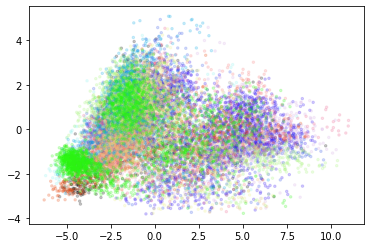

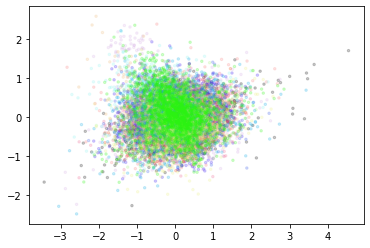

In [41]:
dataset_idx = [i for i in range(len(valid_set.dataset.datasets)) for _ in range(len(valid_set.dataset.datasets[i]))]
new_cmap = rand_cmap(max(dataset_idx), type='bright', first_color_black=True, last_color_black=False, verbose=False)
plt.scatter(pca_embds[:,0], pca_embds[:,1], c=dataset_idx, alpha=0.2, s=6, cmap=new_cmap)
plt.figure()
plt.scatter(pca_embds[:,2], pca_embds[:,3], c=dataset_idx, alpha=0.2, s=6, cmap=new_cmap)

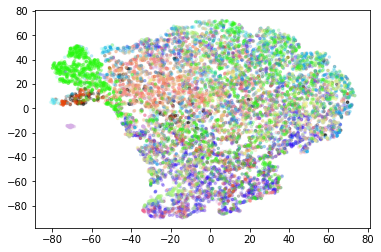

In [42]:
plt.scatter(tsne_embds[:,0], tsne_embds[:,1], c=dataset_idx, alpha=0.2, s=6, cmap=new_cmap)

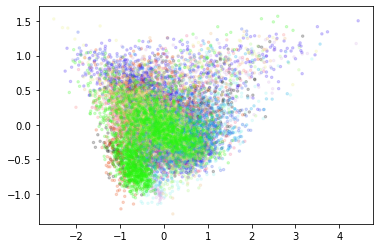

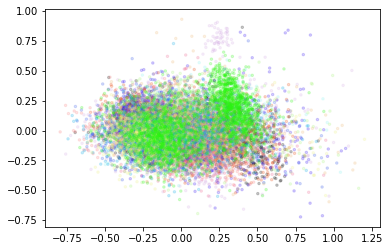

In [43]:
pca = PCA(4)
pca_mns = pca.fit_transform(mns.reshape(mns.shape[0], -1))

plt.scatter(pca_mns[:,0], pca_mns[:,1], c=dataset_idx, alpha=0.2, s=6, cmap=new_cmap)
plt.figure()
plt.scatter(pca_mns[:,2], pca_mns[:,3], c=dataset_idx, alpha=0.2, s=6, cmap=new_cmap)

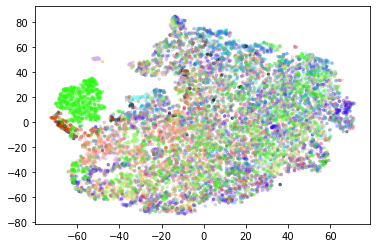

In [44]:
tsne = TSNE(2, n_jobs=-1)
tsne_mns = tsne.fit_transform(mns.reshape(mns.shape[0], -1))
plt.scatter(tsne_mns[:,0], tsne_mns[:,1], c=dataset_idx, alpha=0.2, s=6, cmap=new_cmap)

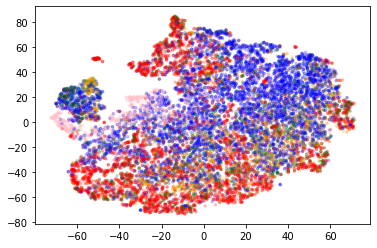

In [45]:
plt.scatter(tsne_mns[:,0], tsne_mns[:,1], c=[['r', 'g', 'b', 'pink', 'orange'][i] for i in sleep_stages], alpha=0.2, s=6)

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

embds_train, embds_test, sleep_stages_train, sleep_stages_test = train_test_split(embds, sleep_stages, test_size=0.99)
print(len(embds_train))
logreg = LogisticRegression(max_iter=1000)
logreg.fit(embds_train.reshape(embds_train.shape[0], -1), sleep_stages_train)
logreg.score(embds_test.reshape(embds_test.shape[0], -1), sleep_stages_test)

167


0.6331925165962583